In [25]:
%run ../Python/PageHD1.py
%matplotlib notebook
import scipy.sparse

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pop_f(R, tuning, weights, f):
    return np.inner(R.T, weights@f(tuning))

def compute_HD(R, tuning, weights=None):
    if weights is None:
        weights = np.identity(tuning.size)
    HD_sin = pop_f(R, tuning, weights, np.sin)
    HD_cos = pop_f(R, tuning, weights, np.cos)
    HD = np.arctan(HD_sin / HD_cos)
    HD[HD_cos < 0] += np.pi
    HD[(HD_sin < 0) & (HD_cos > 0)] += 2*np.pi
    return HD

def read_map(prefix, with_distal=True):
    import csv
    proximal_objs = []
    distal_objs = None
    with open(prefix + '/Agent/map.info', newline='\n') as csvfile:
        mapreader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in mapreader:
            if i == 0:
                bound_x, bound_y = row
                bound_x, bound_y = float(bound_x), float(bound_y)
            elif with_distal and i == 1:
                distal_objs = np.array(row, dtype=float)
            else:
                proximal_objs.append(list(row))
            i += 1
    return (bound_x, bound_y), distal_objs, np.array(proximal_objs, dtype=float)


# Below are from https://gist.github.com/pv/8036995

def edge_project(pts, fd, h0=1.0):
    """
    project points back on the boundary (where fd=0) using numerical gradient

    note : you should specify h0 according to your actual mesh size
    """
    deps = sqrt(np.finfo(float).eps)*h0
    d = fd(pts)
    dgradx = (fd(pts + [deps, 0]) - d) / deps
    dgrady = (fd(pts + [0, deps]) - d) / deps
    dgrad2 = dgradx**2 + dgrady**2
    dgrad2[dgrad2 == 0] = 1.
    # calculate gradient vector (minus)
    pgrad = np.vstack([d*dgradx/dgrad2, d*dgrady/dgrad2]).T
    return pgrad

from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, rate_map, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    rates = []
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        rates.append(rate_map[tuple(vor.points[p1].tolist())])
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        try:
            ridges = all_ridges[p1]
        except KeyError:
            rates = rates[:-1]
            continue
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())
        
    return new_regions, np.asarray(new_vertices), rates

In [52]:
outdir = '../Build/pandapics/AHVxHD_simple_smoothAHV' #_no_PLACE_20170925'
rate_buf_ival = 2**-6
weights_buf_ival = 10.0

bounds, distal_objects, proximal_objects = read_map(outdir, with_distal=True)
bound_x = bounds[0]
bound_y = bounds[1]

num_objects = proximal_objects.shape[0] + distal_objects.shape[0]
#print(proximal_objects)
print(distal_objects)

N_HD = 300
N_AHV = 3 * 100
N_AHVxHD = 600

[ 0.]


In [599]:
test_start_t = 16000 # 2080 # 101 # 1017 # 355
test_stop_t = test_start_t + 51 # 1022
test_start_i = int(test_start_t/rate_buf_ival)
test_stop_i = int(test_stop_t/rate_buf_ival)

<IPython.core.display.Javascript object>


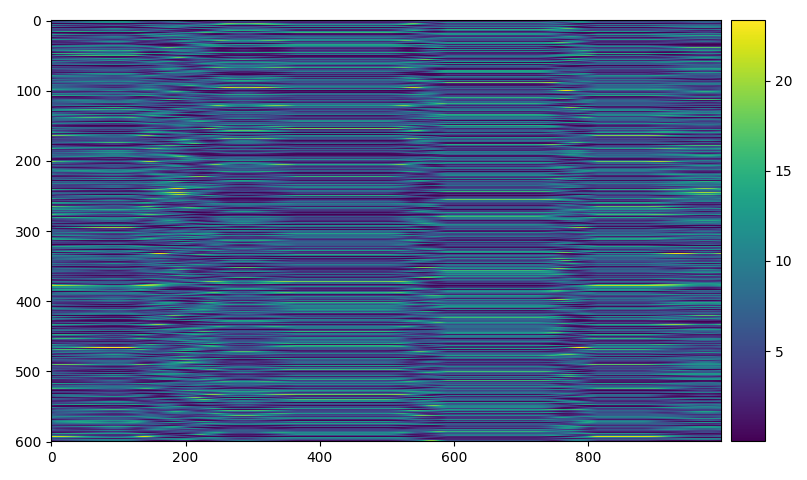

<IPython.core.display.Javascript object>


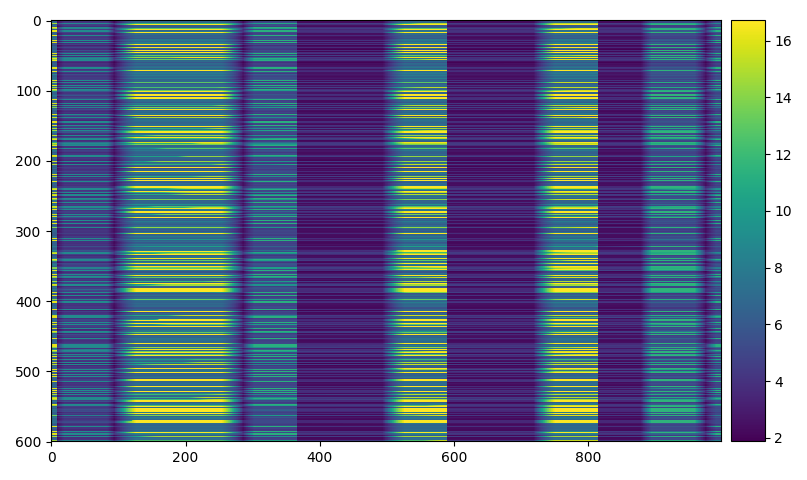

<IPython.core.display.Javascript object>


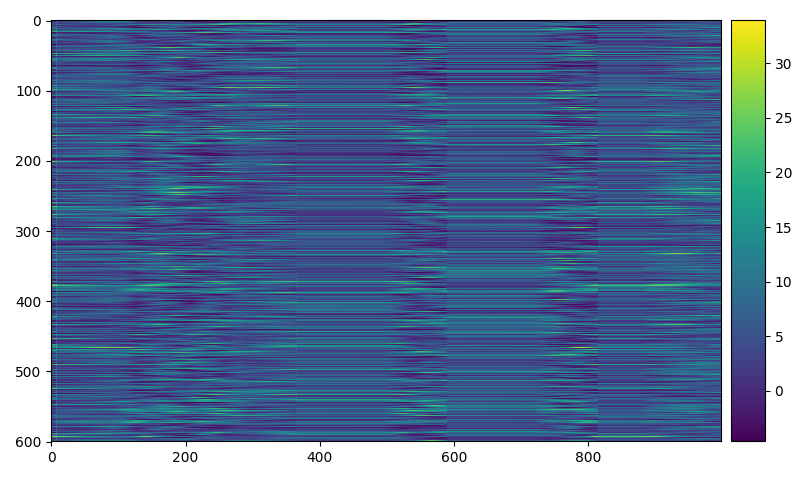

515


<IPython.core.display.Javascript object>


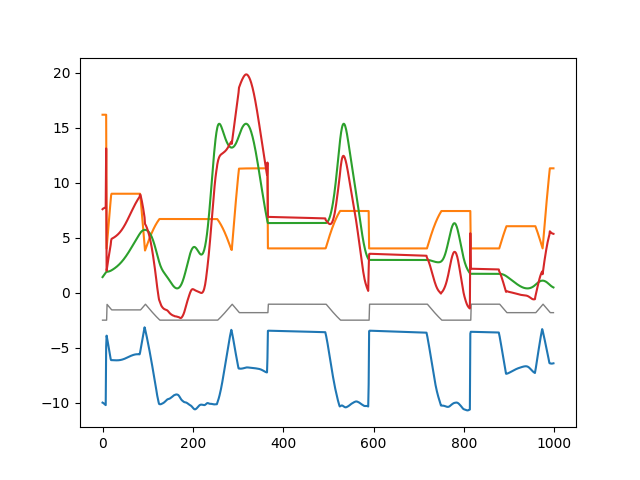

<IPython.core.display.Javascript object>


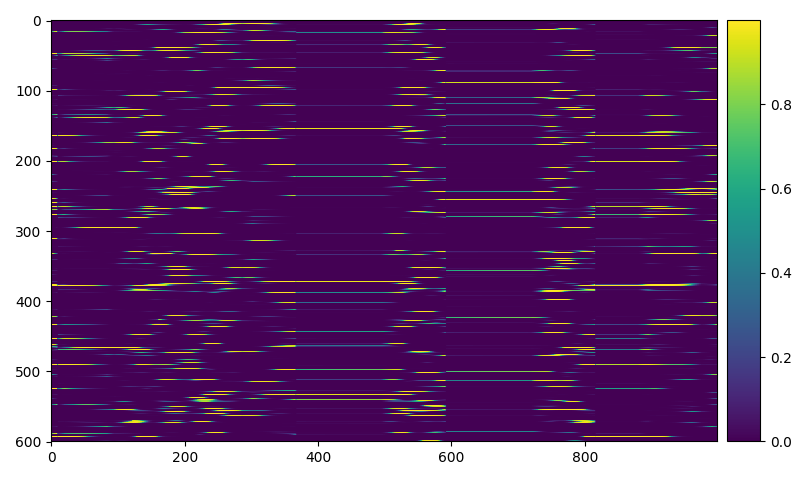

<IPython.core.display.Javascript object>


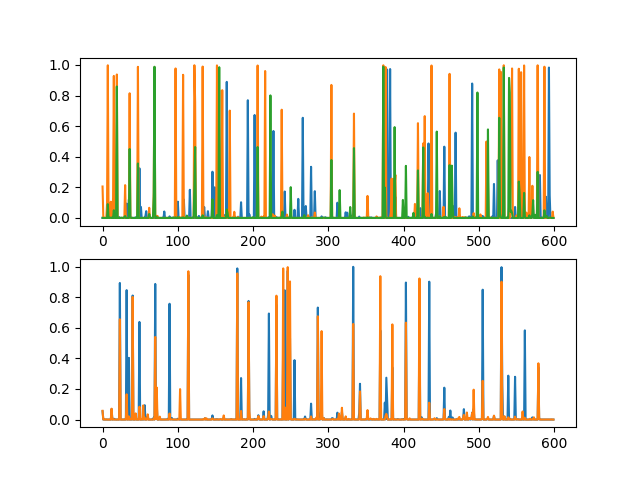

-6.48129 6.15608 6.21555
Sparsity: 0.040530


In [596]:
start, stop = -1000, -1 # test_start_i, test_stop_i

R_AHVxHD = np.array(read_rates(outdir, 'AHVxHD', N_AHVxHD)[:, start:stop])
R_AHV = read_rates(outdir, 'AHV', N_AHV)[:, start:stop]

H_AHVxHD_INH = accumulate_activation(outdir, 'AHVxHD', ['AHVxHD'], N_AHVxHD, slice(start, stop), INH=True) # 'HD'
H_AHV_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['AHV'], N_AHVxHD, slice(start, stop))
H_HD_AHVxHD = accumulate_activation(outdir, 'AHVxHD', ['HD'], N_AHVxHD, slice(start, stop))
H_AHVxHD = H_AHVxHD_INH + H_HD_AHVxHD + H_AHV_AHVxHD
imshow(H_HD_AHVxHD)
imshow(H_AHV_AHVxHD)
imshow(H_AHVxHD)#[W_idx_s])

# blue, orange, green, red, purple
j = np.random.choice(np.where(np.max(R_AHVxHD, 1) > 0.9)[0])
print(j)
fig, ax = plt.subplots()
ax.plot(R_AHV[0]*np.min(H_AHVxHD_INH[j]), color='gray', lw=1)
ax.plot(H_AHVxHD_INH[j])
ax.plot(H_AHV_AHVxHD[j])
ax.plot(H_HD_AHVxHD[j])
ax.plot(H_AHVxHD[j])

imshow(R_AHVxHD)#[W_idx_s])
fig, ax = plt.subplots(2)
ax = ax.flatten()
ax[0].plot(R_AHVxHD[:,10])
ax[0].plot(R_AHVxHD[:,250])
ax[0].plot(R_AHVxHD[:,500])
ax[1].plot(R_AHVxHD[:, -1])
ax[1].plot(R_AHVxHD[:, -17])

print(np.mean(H_AHVxHD_INH), np.mean(H_AHV_AHVxHD), np.mean(H_HD_AHVxHD))
print('Sparsity: %f' % (np.mean(np.sum(R_AHVxHD, 0)) / N_AHVxHD))

In [ ]:
agent_hist = read_rates(outdir, 'Agent', 6, fname='history.bin')
fig, ax = plt.subplots()
ax.set_xlim(-bound_x, bound_x)
ax.set_ylim(-bound_x, bound_y)
try: ax.scatter(proximal_objects[:, 0], proximal_objects[:, 1])
except IndexError: pass
ax.plot(agent_hist[0][test_start_i:test_stop_i], agent_hist[1][test_start_i:test_stop_i])
ax.plot()

fig, ax = plt.subplots(3)
ax = ax.flatten()
ax[0].plot(agent_hist[5][test_start_i:test_stop_i], agent_hist[0][test_start_i:test_stop_i])
ax[0].plot(agent_hist[5][test_start_i:test_stop_i], agent_hist[1][test_start_i:test_stop_i])
ax[1].plot(agent_hist[5][test_start_i:test_stop_i], agent_hist[2][test_start_i:test_stop_i])
ax[2].plot(agent_hist[5][test_start_i:test_stop_i], agent_hist[4][test_start_i:test_stop_i])

<IPython.core.display.Javascript object>


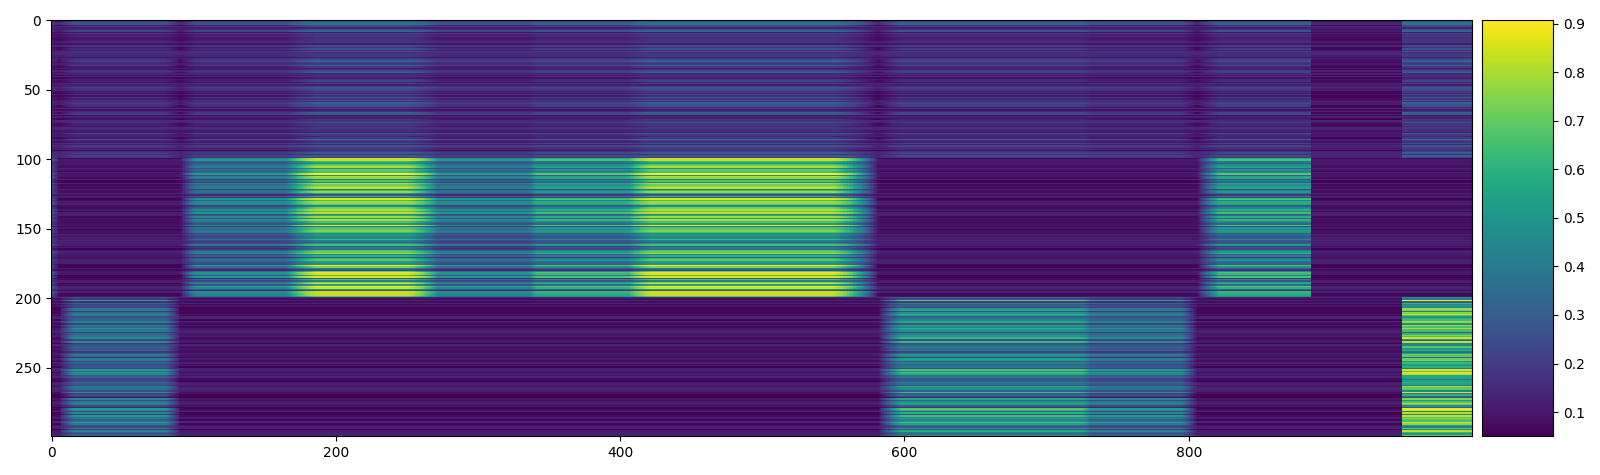

Sparsity: 0.226710


In [443]:
R_AHV = read_rates(outdir, 'AHV', N_AHV)
imshow(R_AHV[:, -1000:])#test_start_i:test_stop_i])
print('Sparsity: %f' % (np.mean(np.sum(R_AHV, 0)) / N_AHV))

<IPython.core.display.Javascript object>


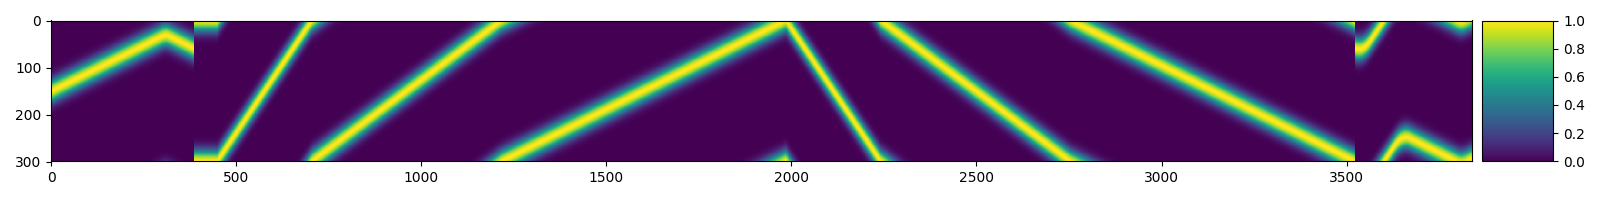

Sparsity: 0.139257


In [146]:
R_HD = read_rates(outdir, 'HD', N_HD)[:, test_start_i:test_stop_i]
imshow(R_HD)
print('Sparsity: %f' % (np.mean(np.sum(R_HD, 0)) / N_HD))

<IPython.core.display.Javascript object>


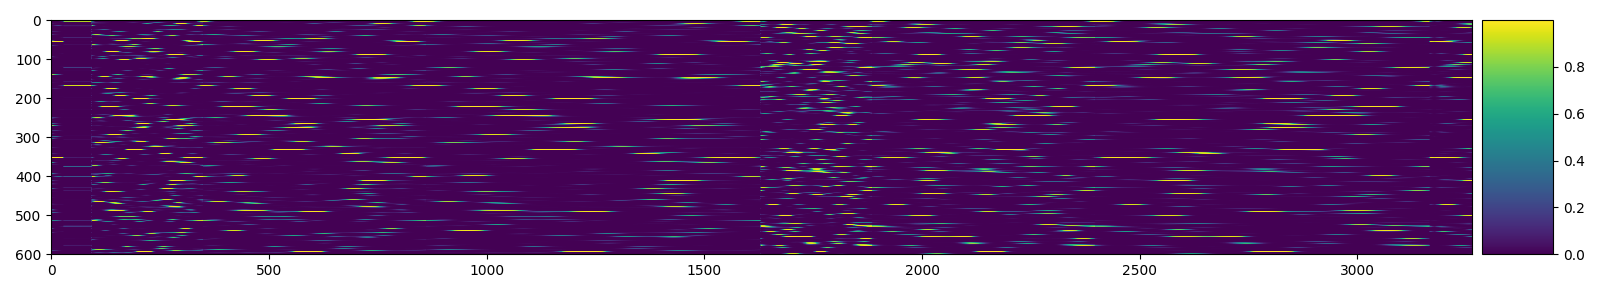

<IPython.core.display.Javascript object>


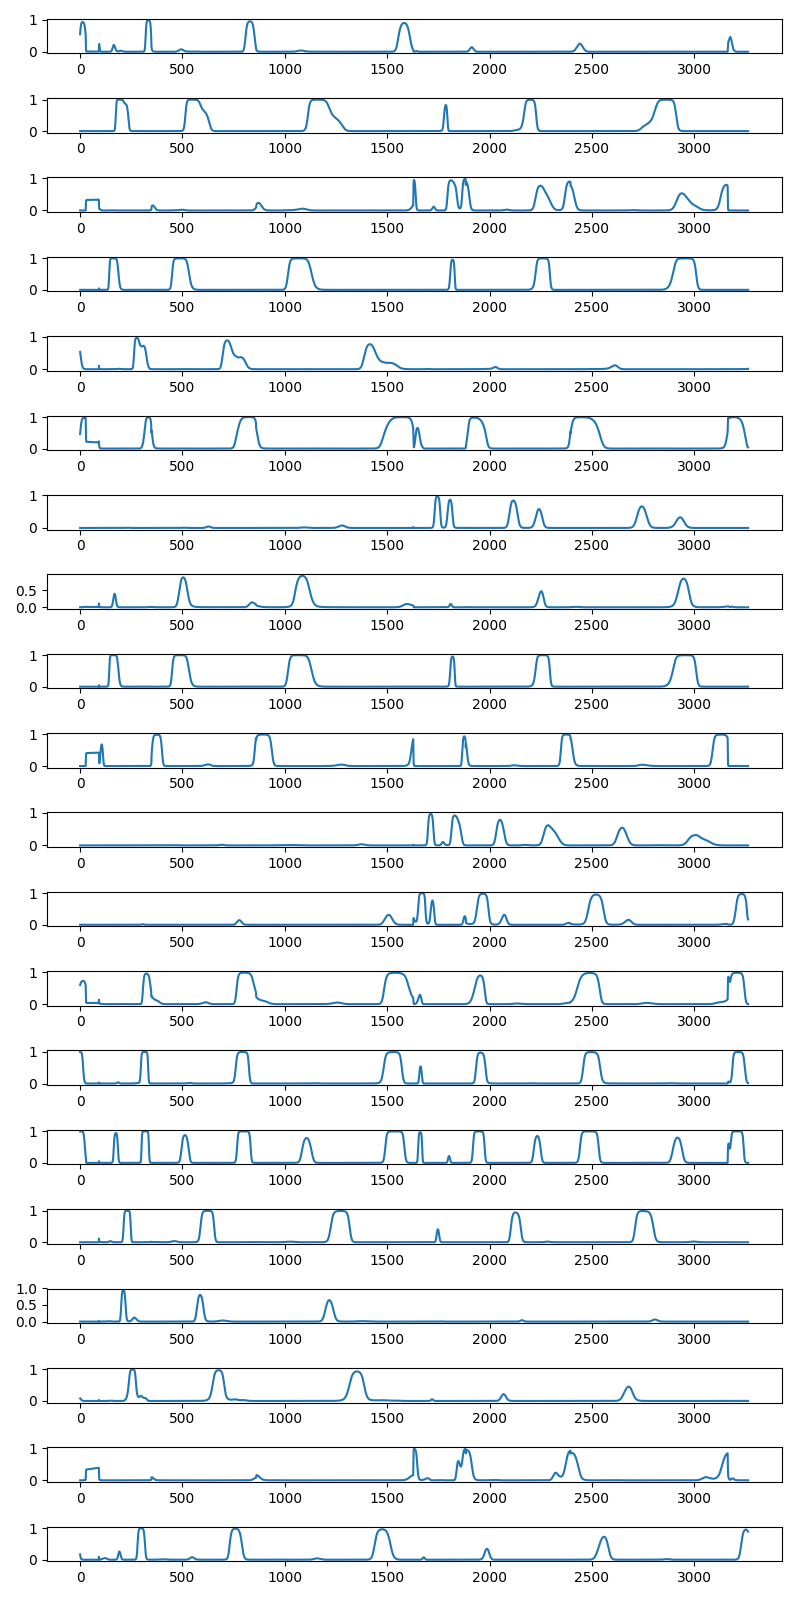

Sparsity: 0.047159


array([  1, 434, 376, 249, 305, 563, 573, 231, 249, 122,  45, 510, 443,
       549, 385, 433, 260, 508, 544, 424])

In [600]:
R_AHVxHD = read_rates(outdir, 'AHVxHD', N_AHVxHD)[:, test_start_i:test_stop_i]
imshow(R_AHVxHD)
J = np.where(np.max(R_AHVxHD, 1) > 0.9)[0]
J = np.random.choice(J, 20)
#n_plot = 20
n_plot = len(J)
fig, ax = plt.subplots(n_plot, figsize=(8, 0.8*n_plot), tight_layout=True)
ax = ax.flatten()
# J = np.random.choice(J, n_plot) # np.random.randint(0, np.min(N_AHVxHD), n_plot)
for i in np.arange(n_plot):
    ax[i].plot(R_AHVxHD[J[i]])
print('Sparsity: %f' % (np.mean(np.sum(R_AHVxHD, 0)) / N_AHVxHD))
J

<IPython.core.display.Javascript object>


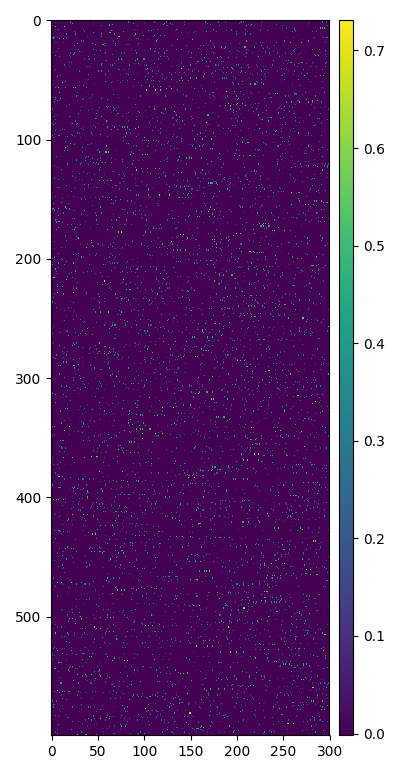

<IPython.core.display.Javascript object>


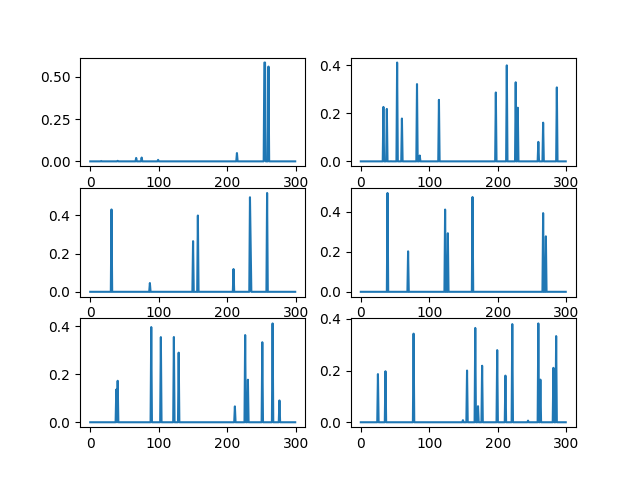

1.00004
1.00001


In [120]:
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1] # - read_weights(outdir, 'AHVxHD', 'HD', 500, 1000)[0]
#W_idx = np.indices((W_AHVxHD_HD[-1].shape[0],))[0] + 1
#W_idx_s = np.argsort(W_HD_AHVxHD @ HD_tuning) # np.sum(W_AHVxHD_HD[-1].T * W_idx, 1))[::-1]

imshow(W_HD_AHVxHD)# - W_AHVxHD_HD[0][:, W_idx_s])

fig, ax = plt.subplots(3,2)
ax = ax.flatten()
ax[0].plot(W_HD_AHVxHD[-10, :])
ax[1].plot(W_HD_AHVxHD[-50, :])
ax[2].plot(W_HD_AHVxHD[-100, :])
ax[3].plot(W_HD_AHVxHD[-200, :])
ax[4].plot(W_HD_AHVxHD[50, :])
ax[5].plot(W_HD_AHVxHD[10, :])

print(np.linalg.norm(W_HD_AHVxHD[-10, :]))
print(np.linalg.norm(W_HD_AHVxHD[1, :]))

#imshow(W_HD_AHVxHD)

<IPython.core.display.Javascript object>


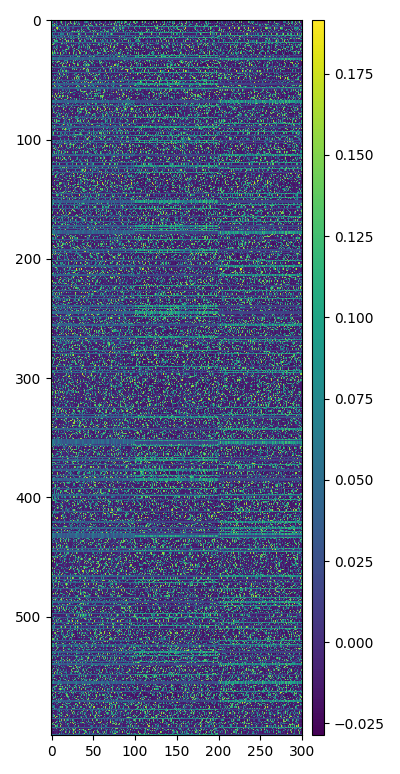

1.0
0.166274 0.164578 0.669149


In [431]:
W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD_cum = np.c_[np.sum(W_AHV_AHVxHD[:,:100], 1),
                         np.sum(W_AHV_AHVxHD[:,100:200], 1),
                         np.sum(W_AHV_AHVxHD[:,200:], 1)]
imshow(W_AHV_AHVxHD)#[np.argsort(W_AHV_AHVxHD_cum@np.array([25,75,125]))])
print(np.linalg.norm(W_AHV_AHVxHD[10]))
print(np.sum(W_AHV_AHVxHD[:,:50])/np.sum(W_AHV_AHVxHD),
      np.sum(W_AHV_AHVxHD[:,50:100])/np.sum(W_AHV_AHVxHD),
      np.sum(W_AHV_AHVxHD[:,100:])/np.sum(W_AHV_AHVxHD))

/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


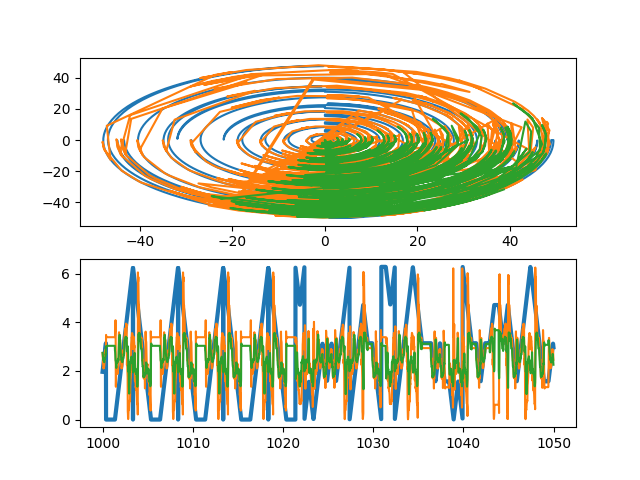

4.98941492643
3.96284581254
0.765925774476


In [31]:
N_VIS_per_obj = (N_VIS // num_objects)
VIS_tuning = 2 * np.pi * np.arange(N_VIS_per_obj, dtype=float) / N_VIS_per_obj
VIS_tuning = np.concatenate([VIS_tuning] * num_objects)
VIS_in_tuning = VIS_tuning.copy()
VIS_in_tuning[(N_VIS_per_obj*distal_objects.shape[0]):] = 0

W_VIS_HD = read_weights(outdir, 'HD', 'VIS', N_VIS, N_HD)[int(test_start_t/weights_buf_ival)-1]
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[int(test_start_t/weights_buf_ival)-1]
R_HD = read_rates(outdir, 'HD', N_HD)
R_AHVxHD = read_rates(outdir, 'AHVxHD', N_AHVxHD)
R_VIS_in = read_rates(outdir, 'VIS', N_VIS)
#R_VIS = read_rates(outdir, 'VIS_cf', N_VIS)

#HD_true = compute_HD(R_VIS, VIS_tuning)
HD_true = read_rates(outdir, 'Agent', 3, fname='history.bin')[2]
HD_in = compute_HD(R_VIS_in, VIS_in_tuning)
HD_HD = compute_HD(R_HD, VIS_tuning, W_VIS_HD)
HD_AHVxHD = compute_HD(R_AHVxHD, VIS_tuning, W_HD_AHVxHD@W_VIS_HD)

fig, ax = plt.subplots(2) #3)
ax = ax.flatten()
time = (np.arange(test_start_i, test_stop_i) - test_start_i) * rate_buf_ival
ax[0].plot(time*(np.sin(HD_true)[test_start_i:test_stop_i]),
           time*(np.cos(HD_true)[test_start_i:test_stop_i]))
#ax[0].plot(time*(np.sin(HD_in)[test_start_i:test_stop_i]),
#           time*(np.cos(HD_in)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_HD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_HD)[test_start_i:test_stop_i]))
ax[0].plot(time*(np.sin(HD_AHVxHD)[test_start_i:test_stop_i]),
           time*(np.cos(HD_AHVxHD)[test_start_i:test_stop_i]))

ax[1].plot(time+test_start_t, HD_true[test_start_i:test_stop_i], lw=3)
#ax[1].plot(time+test_start_t, HD_in[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_HD[test_start_i:test_stop_i])
ax[1].plot(time+test_start_t, HD_AHVxHD[test_start_i:test_stop_i])

#min_len = np.min((len(HD_true), len(HD_HD)))
#ax[2].plot(moving_average((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2, 10))

print(np.mean((HD_true[test_start_i:test_stop_i]-HD_HD[test_start_i:test_stop_i])**2))
print(np.mean((HD_true[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
print(np.mean((HD_HD[test_start_i:test_stop_i]-HD_AHVxHD[test_start_i:test_stop_i])**2))
#TODO: plot moving average of the error

[ 17 128 133]


/home/toby/Virtual/virtualenv/oftnai/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


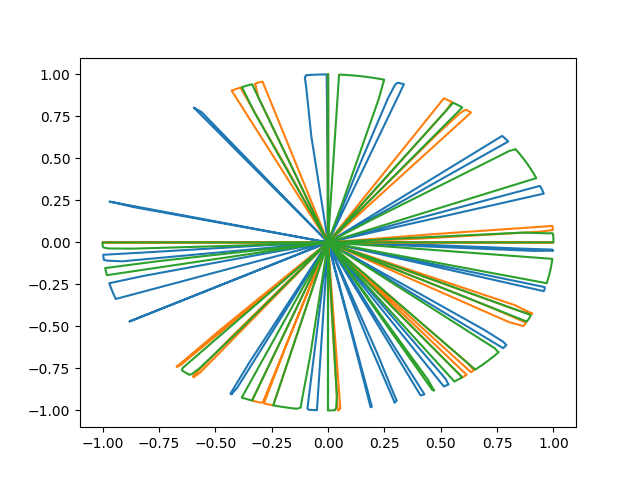

In [34]:
HD_sparsity = np.mean(np.sum(R_HD[:, test_start_i:test_stop_i], 0)) / N_HD
J = np.random.choice(np.arange(N_HD), 3, replace=False) # int(N_HD*HD_sparsity)
print(J)
fig, ax = plt.subplots()
for j in J:
    _theta_tmp = HD_true[test_start_i:test_stop_i]
    _r_tmp = R_HD[j, test_start_i:test_stop_i]#[np.argsort(_theta_tmp)]
    _theta_tmp = sorted(_theta_tmp)
    ax.plot(_r_tmp*(np.sin(_theta_tmp)),
            _r_tmp*(np.cos(_theta_tmp)), '-')

In [1201]:
W_HD_AHVxHD = read_weights(outdir, 'AHVxHD', 'HD', N_HD, N_AHVxHD)[-1]
#W_HD_AHVxHD = scipy.sparse.rand(W_HD_AHVxHD.shape[0], W_HD_AHVxHD.shape[1], 0.05, dtype=np.float32).todense()
##W_tmp = W_HD_AHVxHD.copy()
##W_tmp__ = W_HD_AHVxHD.copy()
##W_tmp[W_idx_s[-N_REPLACE:], :][W_tmp[W_idx_s[-N_REPLACE:], :] > 0] = 0.1
W_HD_AHVxHD.tofile('VIS/W_HD_AHVxHD.bin')

W_AHV_AHVxHD = read_weights(outdir, 'AHVxHD', 'AHV', N_AHV, N_AHVxHD)[-1]
W_AHV_AHVxHD.tofile('VIS/W_AHV_AHVxHD.bin')

#imshow(W_HD_AHVxHD)

In [275]:
plt.close('all')

<IPython.core.display.Javascript object>


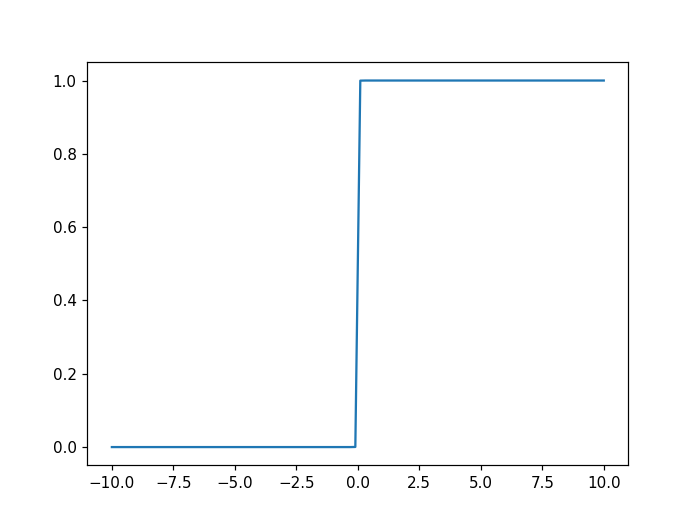

In [1495]:
fig, ax = plt.subplots()
X = np.linspace(-10, 10, 100)
ax.plot(X, 0.5*(np.tanh(40*X)+1))